## Set Up + Imports

In [43]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from gtda.diagrams import PairwiseDistance
from gtda.homology import WeakAlphaPersistence
from gtda.plotting import plot_diagram, plot_heatmap
from plotly.subplots import make_subplots

import neurometry.curvature.datasets.experimental as experimental
import neurometry.curvature.datasets.gridcells as gridcells
import neurometry.curvature.persistent_homology as persistent_homology
import neurometry.curvature.viz as viz
from neurometry.curvature.datasets.synthetic import (
    load_s2_synthetic,
    load_t2_synthetic,
)

Working directory:  /Users/facosta/Desktop/code/neurometry/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry/neurometry
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Persistence homology for synthetic sphere, torus point clouds

### Generate point clouds

In [93]:
dim = 3

sphere_point_cloud, sphere_labels = load_s2_synthetic(
    "random",
    n_times=400,
    radius=1,
    geodesic_distortion_amp=0,
    embedding_dim=dim,
    noise_var=0.001,
)
sphere_point_cloud = np.array(sphere_point_cloud)

torus_point_cloud, torus_labels = load_t2_synthetic(
    "random",
    n_times=1800,
    major_radius=2,
    minor_radius=1,
    geodesic_distortion_amp=0,
    embedding_dim=dim,
    noise_var=0.0001,
)

torus_point_cloud = np.array(torus_point_cloud)

### Plot point clouds

In [94]:
s2_x, s2_y, s2_z = sphere_point_cloud.T

t2_x, t2_y, t2_z = torus_point_cloud.T

fig = make_subplots(
    rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]]
)


fig.add_trace(
    go.Scatter3d(
        x=s2_x, y=s2_y, z=s2_z, mode="markers", marker=dict(color="red", size=3)
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter3d(
        x=t2_x, y=t2_y, z=t2_z, mode="markers", marker=dict(color="orange", size=3)
    ),
    row=1,
    col=2,
)

fig.update_layout(
    width=1000,
    height=500,
    title_text="3D Scatter Plots of Sphere and Torus Point Clouds with Smaller Points",
)

fig.show()

In [110]:
# Compute the 0, 1 and 2-dimensional homology of the point clouds
homology_dimensions = (0, 1, 2)
WA = WeakAlphaPersistence(homology_dimensions=homology_dimensions)

# Compute the persistence diagrams
diagrams = WA.fit_transform([sphere_point_cloud, torus_point_cloud])
print(diagrams.shape)

(2, 3158, 3)


In [112]:
fig_sphere = plot_diagram(
    diagrams[0],
    homology_dimensions=(0, 1, 2),
    plotly_params={"title": "Sphere"},
)
fig_sphere.update_layout(title="Sphere")

In [113]:
fig_torus = plot_diagram(
    diagrams[1],
    homology_dimensions=(0, 1, 2),
    plotly_params={"title": "Torus"},
)

fig_torus.update_layout(title="Torus")

### Persistence diagrams for synthetic 2-torus

In [7]:
diagrams = persistent_homology.compute_persistence_diagrams(
    torus_point_cloud, maxdim=2, n_threads=-1
)

'compute_persistence_diagrams' executed in 41.9059s


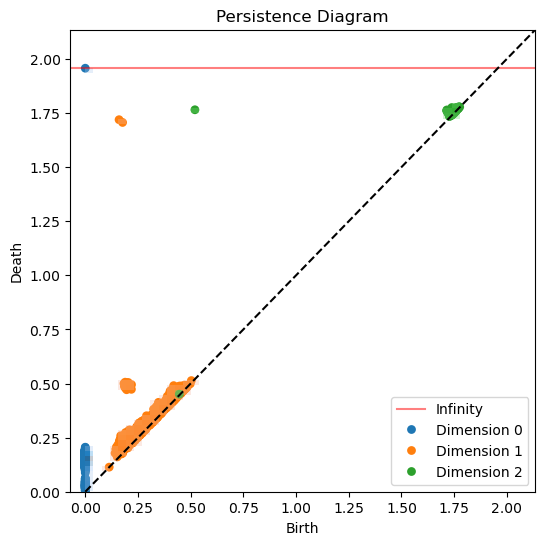

In [8]:
viz.plot_persistence_diagrams(diagrams, density=True)

## Compute Bottleneck Distance between Persistence Diagrams

Create torus point clouds with varying levels of noise

In [136]:
noise_var = np.logspace(-5, 0, 15)

tori = []

for noise in noise_var:
    torus, _ = load_t2_synthetic(
        None,
        n_times=1800,
        major_radius=2,
        minor_radius=1,
        geodesic_distortion_amp=0,
        embedding_dim=dim,
        noise_var=noise,
    )
    tori.append(torus)

Compute persistence diagrams for tori and compute pairwise bottleneck distance

In [137]:
# Compute the 0, 1 and 2-dimensional homology of the torus
homology_dimensions = (0, 1, 2)
WA = WeakAlphaPersistence(homology_dimensions=homology_dimensions)

# Compute the diagrams for the tori
diagrams = WA.fit_transform(tori)
print(diagrams.shape)

# Compute the bottleneck distance between the diagrams
PD = PairwiseDistance(metric="bottleneck", n_jobs=-1)

distance = PD.fit_transform(diagrams)
print(distance.shape)

(15, 3747, 3)
(15, 15)


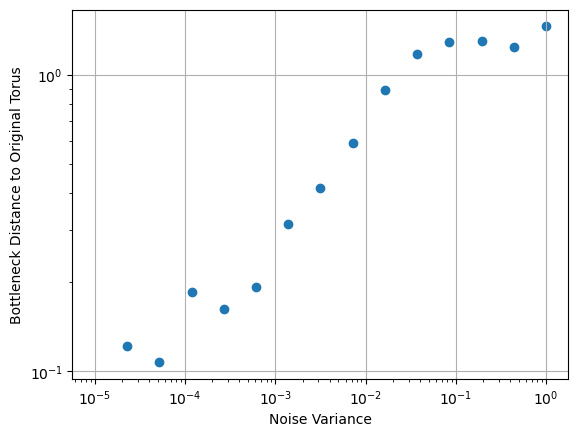

In [138]:
plt.scatter(noise_var, distance[0, :], label="0D")
# make the plot look nice
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Noise Variance")
plt.ylabel("Bottleneck Distance to Original Torus")

plt.grid()

In [139]:
plot_heatmap(distance, colorscale="blues")

In [15]:
# diagram_0 = persistent_homology.compute_persistence_diagrams(
#     torus_0, maxdim=2, n_threads=-1
# )

# diagram_1 = persistent_homology.compute_persistence_diagrams(
#     torus_1, maxdim=2, n_threads=-1
# )

'compute_persistence_diagrams' executed in 46.4076s
'compute_persistence_diagrams' executed in 31.8140s


## Persistence homology for place cell data

### Load place cell data 

From Ravikrishnan P Jayakumar, Manu S Madhav, Francesco Savelli, Hugh T Blair, Noah J Cowan, and James J Knierim. Recalibration of path integration in hippocampal place cells. Nature, 566(7745):533–537, 2019.

In [8]:
expt_id = 34
timestep = int(1e6)

dataset, labels = experimental.load_neural_activity(
    expt_id=expt_id, timestep_microsec=timestep
)
dataset = dataset[labels["velocities"] > 5]
labels = labels[labels["velocities"] > 5]
dataset = np.log(dataset.astype(np.float32) + 1)
dataset.shape

INFO: # - Found file at /home/facosta/neurometry/neurometry/data/binned/expt34_times_timestep1000000.txt! Loading...
INFO: # - Found file at /home/facosta/neurometry/neurometry/data/binned/expt34_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at /home/facosta/neurometry/neurometry/data/binned/expt34_labels_timestep1000000.txt! Loading...


(934, 40)

### Persistence diagrams for place cell data

Function 'compute_persistence_diagrams' executed in 1.6295s


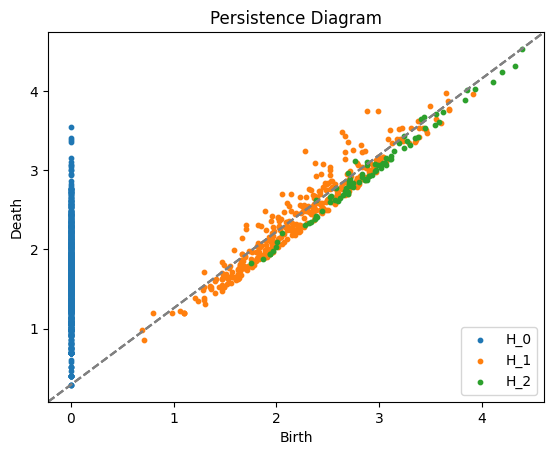

In [9]:
place_cell_diagrams = compute_persistence_diagrams(dataset, maxdim=2, n_threads=-1)
plot_persistence_diagrams(place_cell_diagrams)

## Synthetic Grid cell data

### Generate synthetic grid cell data + compute persistence diagrams

Orientation variability = 0

In [3]:
grid_scale = 1
arena_dims = np.array([4, 4])
n_cells = 256
grid_orientation_mean = 0
grid_orientation_std = 0

field_width = 0.05
resolution = 50

neural_activity, _ = gridcells.load_grid_cells_synthetic(
    grid_scale,
    arena_dims,
    n_cells,
    grid_orientation_mean,
    grid_orientation_std,
    field_width,
    resolution,
)
print("shape of neural activity matrix: " + str(neural_activity.shape))

shape of neural activity matrix: (2500, 256)


Function 'compute_persistence_diagrams' executed in 4809.5422s


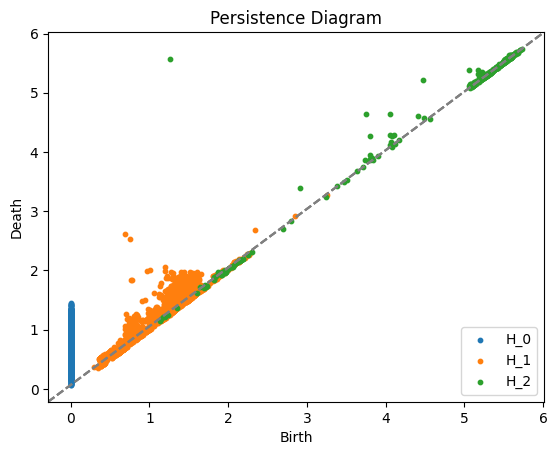

In [4]:
diagrams = compute_persistence_diagrams(neural_activity, maxdim=2, n_threads=-1)
plot_persistence_diagrams(diagrams)

#### Orientation variability > 0

In [5]:
grid_scale = 1
arena_dims = np.array([4, 4])
n_cells = 256
grid_orientation_mean = 0
grid_orientation_std = 3

field_width = 0.05
resolution = 50

neural_activity, _ = gridcells.load_grid_cells_synthetic(
    grid_scale,
    arena_dims,
    n_cells,
    grid_orientation_mean,
    grid_orientation_std,
    field_width,
    resolution,
)
print("shape of neural activity matrix: " + str(neural_activity.shape))

shape of neural activity matrix: (2500, 256)
